# Effect of Ensembling on Simplicity Bias
Recall that we define extreme simplicity bias (SB) as the tendency of neural networks trained with SGD or variants to learn a small-margin classifier that exclusively relies on the simplest feature and remain invariant to all complex features. In this notebook, we show that ensembles of independently trained models do not mitigate simplicity bias in the synthetic slab-structured and mnist-cifar datasets. For more details, please have a look at Appendix E.1 of the [paper](https://arxiv.org/abs/2006.07710). 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from imports import *
from cifar10_models import cifar10_models as c10

DEVICE_ID = 1 # GPU_ID or None (CPU)

## Ensembles of FCN trained on LMS-5

Text(0.5, 0.98, 'LMS-5')

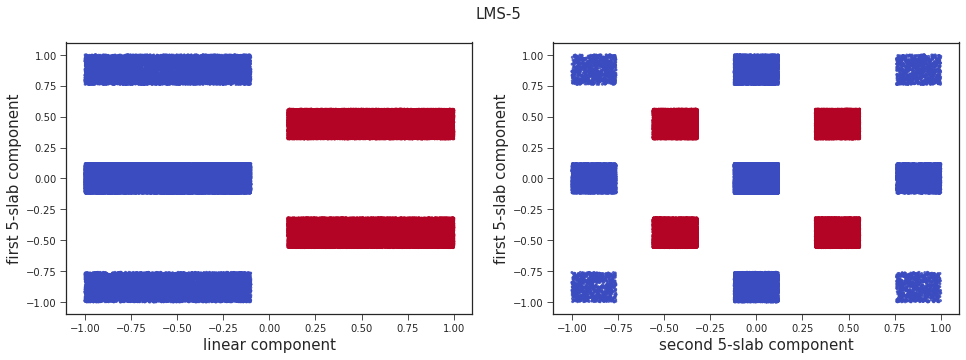

In [2]:
# load and visualize LMS data

c = config =  {
    'num_train': 100_000, # training dataset size
    'dim': 50, # input dimension
    'lin_margin': 0.1, # linear margin
    'slab_margin': 0.1, # slab margin,
    'same_margin': True, # keep same margin
    'random_transform': True, # apply random (orthogonal) transformation
    'width': 1, # data width in standard basis
    'num_lin': 1, # number of linear components
    'num_slabs': 49, #. number of 5 slabs
    'num_slabs7': 0, # number of 7 slabs
    'num_slabs3': 0, # number of 3 slabs
    'bs': 256, # batch size
    'corrupt_lin': 0.0, # p_noise
    'corrupt_lin_margin': True, # noise model
    'corrupt_slab': 0.0, # slab corruption
    'num_test': 10_000, # test dataset size
    'hdim': 100, # model width
    'hl': 2, # model depth
    'mtype': 'fcn', # model architecture
    'device': gu.get_device(DEVICE_ID), # GPU device
    'lr': 0.1, # step size
    'weight_decay': 5e-5 # weight decay
}

data = get_data(**c)

# visualize LMS data
fig, (ax, ax_) = plt.subplots(1,2,figsize=(16, 5))
W = data['W']
X, Y = data['X'], data['Y']
X = X.numpy().dot(W.T)
ax.scatter(X[:,0], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax.set_xlabel('linear component', fontsize=15)
ax.set_ylabel('first 5-slab component', fontsize=15)

ax_.scatter(X[:,2], X[:,1], c=Y, cmap='coolwarm', s=4, alpha=0.8) 
ax_.set_xlabel('second 5-slab component', fontsize=15)
ax_.set_ylabel('first 5-slab component', fontsize=15)
fig.suptitle('LMS-5', fontsize=15)

In [3]:
# independently train multiple FCNs
ENS_SIZE = 3
models = []

for _ in range(ENS_SIZE):
    model = synth_models.get_fcn(idim=c['dim'], hdim=c['hdim'], odim=2, hl=c['hl']).to(c['device'])
    opt = optim.SGD(model.parameters(), lr=c['lr'], weight_decay=c['weight_decay'])

    stats = utils.fit_model(model, F.cross_entropy, opt, data['tr_dl'], 
                            data['te_dl'], gap=5000, device=c['device'],
                            epsilon=0.0001, patience_updates=1000)
    
    model = stats['best_model'][-1].cpu() # pick the model with best validation accuracy
    models.append(model)

accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.0001, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.5165 0.5197 0.6885
5000 1.0000 1.0000 0.0003
converged after 12 epochs in 0.0m 20.043583s, gap: 0.0
init-ing patience (1000 updates)
6000 1.0000 1.0000 0.0003
accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.0001, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.5464 0.5367 0.6891
5000 1.0000 1.0000 0.0003
converged after 12 epochs in 0.0m 17.351789s, gap: 0.0
init-ing patience (1000 updates)
6000 1.0000 1.0000 0.0003
accuracy/loss measured every 5000 updates
update_print_gap: 5000, epss: 0.0001, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.4982 0.4940 0.7007
5000 1.0000 1.0000 0.0003
converged after 12 epochs in 0.0m 17.258755s, gap: 0.0
init-ing patience (1000 updates)
6000 1.0000 1.0000 0.0003


In [4]:
# make and evaluate ensemble 
# check the ensemble module to evaluate alternative methods of aggregating model predictions
model = ensemble.EnsembleAverage(models).to(c['device'])

# compute standard, S-randomized and S^c-randomized AUC 
std_auc = utils.get_binary_auc(model, data['te_dl'], c['device'])

# get S-randomized and S^c-randomized datasets 
s_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], [0]) # randomize linear coordinate
sc_rand_dl = lms_utils.get_randomized_loader(data['te_dl'], data['W'], list(range(1, c['dim']))) # randomize all 49 5-slab coordinates

# compute randomized AUC
s_rand_auc = utils.get_binary_auc(model, s_rand_dl, c['device']) 
sc_rand_auc = utils.get_binary_auc(model, sc_rand_dl, c['device']) 

print ('Standard AUC: {:.3f}'.format(std_auc))
print ('Linear-Randomized or S-Randomized AUC: {:.3f}'.format(s_rand_auc))
print ('Slabs-Randomized or Sc-Randomized AUC: {:.3f}'.format(sc_rand_auc))

Standard AUC: 1.000
Linear-Randomized or S-Randomized AUC: 0.507
Slabs-Randomized or Sc-Randomized AUC: 1.000


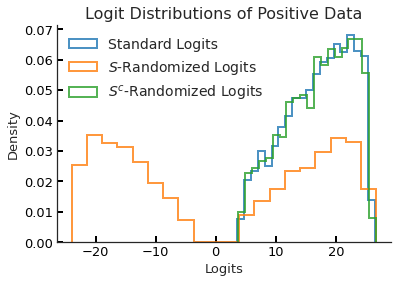

In [5]:
"""
logits "score" distribution of positive data points
The distribution remain essentially the same even after randomizing all complex features (5-slab coordinates)
The logits get randomly shuffled across classes after randomized the linear feature (linear coordinate)
"""
def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

# compute logit scores
std_log = get_logits(model, data['te_dl'], c['device'])
s_rand_log = get_logits(model, s_rand_dl, c['device'])
sc_rand_log = get_logits(model, sc_rand_dl, c['device'])

# plot logit distributions
kw = dict(kde=False, bins=20, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax = sns.distplot(std_log, label='Standard Logits', **kw)
ax = sns.distplot(s_rand_log, label=r'$S$-Randomized Logits', **kw)
ax = sns.distplot(sc_rand_log, label=r'$S^c$-Randomized Logits', **kw)

utils.update_ax(ax, 'Logit Distributions of Positive Data', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

Coordinate-wise randomized accuracies:
0:0.497 1:1.000 2:1.000 3:1.000 4:1.000 5:1.000 6:1.000 7:1.000 8:1.000 9:1.000 10:1.000 11:1.000 12:1.000 13:1.000 14:1.000 15:1.000 16:1.000 17:1.000 18:1.000 19:1.000 20:1.000 21:1.000 22:1.000 23:1.000 24:1.000 25:1.000 26:1.000 27:1.000 28:1.000 29:1.000 30:1.000 31:1.000 32:1.000 33:1.000 34:1.000 35:1.000 36:1.000 37:1.000 38:1.000 39:1.000 40:1.000 41:1.000 42:1.000 43:1.000 44:1.000 45:1.000 46:1.000 47:1.000 48:1.000 49:1.000 



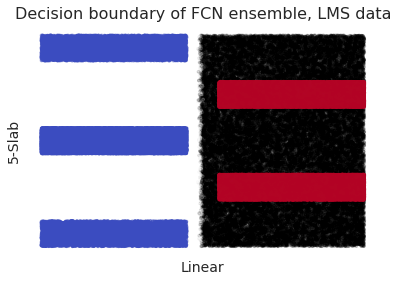

In [6]:
"""
Two-dimensional projection of the model's decision boundary
onto the two most influential coordinates (measured using randomized AUC)
"""
print ("Coordinate-wise randomized accuracies:")
ax = lms_utils.visualize_boundary(model, data, 0, 1, 50, ax=None, is_binary=False, 
                                  width=1, unif_k=True, k=100_000, print_info=True)
utils.update_ax(ax, 'Decision boundary of FCN ensemble, LMS data', 'Linear', '5-Slab', 
                title_fs=16, label_fs=14, legend_loc=False)
sns.despine(ax=ax, bottom=True, left=True); ax.set_xticks([]); ax.set_yticks([])
None

## Ensembles of resnet18s trained on MNIST-CIFAR

In [7]:
# load standard, MNIST-randomized, CIFAR-randomized datasets
mnist_classes = (0, 1)
cifar_classes = (1, 9)
batch_size = 256

tr_dl, te_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                           randomize_mnist=False, randomize_cifar=False)

trm_dl, tem_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=True, randomize_cifar=False)

trc_dl, tec_dl = mc_utils.get_mnist_cifar_dl(mnist_classes=mnist_classes, cifar_classes=cifar_classes, bs=batch_size, 
                                             randomize_mnist=False, randomize_cifar=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


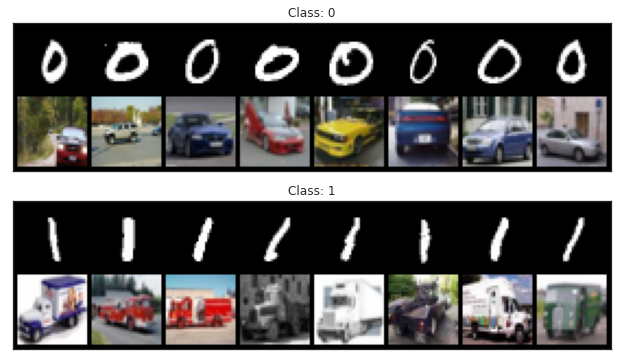

In [8]:
# visualize the standard dataset
_ = utils.visualize_loader_by_class(te_dl)
None

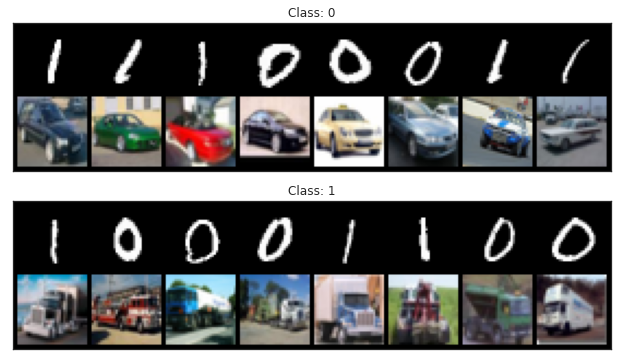

In [9]:
# visualize the MNIST-randomized dataset
_ = utils.visualize_loader_by_class(tem_dl)
None

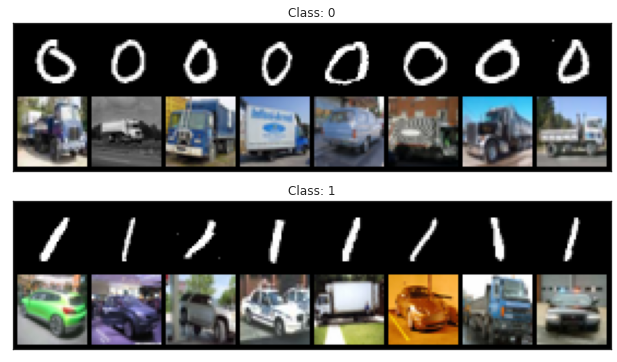

In [10]:
# visualize the CIFAR-randomized dataset
_ = utils.visualize_loader_by_class(tec_dl)
None

In [11]:
# train multiple resnet18s on the data
CE = F.cross_entropy
device = gu.get_device(1) # change GPU device id here 

def lr_scheduler(epoch):
    if epoch < 30: return 1.0
    if 30 <= epoch: return 0.2
    
get_model = lambda: c10.resnet50(device=device, num_classes=2)


ENS_SIZE = 3
models = []

for _ in range(ENS_SIZE):
    model = get_model().to(device)
    opt = optim.SGD(model.parameters(), lr=0.05, weight_decay=5e-5)
    sched = optim.lr_scheduler.LambdaLR(opt, lr_scheduler)
    
    stats = utils.fit_model(model, CE, opt, tr_dl, te_dl, device=device, sch=sched,
                            gap=50, patience_updates=1, is_loss_epsilon=True)
    
    model = stats['best_model'][-1].cpu()
    models.append(model)

accuracy/loss measured every 50 updates
update_print_gap: 50, epss: 0.01, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.5080 0.5000 26.0383
50 0.9600 0.9577 0.1425
100 1.0000 0.9995 0.0002
converged after 2 epochs in 0.0m 37.781860s, gap: 0.0005
init-ing patience (1 updates)
101 1.0000 0.9995 0.0002
accuracy/loss measured every 50 updates
update_print_gap: 50, epss: 0.01, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.5010 0.5000 5.1425
50 0.9668 0.9658 0.0828
100 0.9998 0.9995 0.0018
converged after 2 epochs in 0.0m 29.109111s, gap: 0.0003
init-ing patience (1 updates)
101 0.9998 0.9995 0.0018
accuracy/loss measured every 50 updates
update_print_gap: 50, epss: 0.01, bs: 256, device: cuda:1
#updates, train acc, test acc, train loss
0 0.4947 0.5000 10.5911
50 0.9744 0.9745 0.1511
100 0.9944 0.9959 0.0265
150 0.9999 0.9990 0.0006
converged after 3 epochs in 0.0m 43.238191s, gap: 0.0009
init-ing patience (1 updates)
151 0.9999 0.9990 0.0006


In [12]:
# make and evaluate ensemble
model = ensemble.EnsembleAverage(models).to(device)

Standard AUC: 1.000
MNIST-Randomized AUC: 0.502
CIFAR-Randomized AUC: 1.000


Text(0.5, 0.98, 'Logit Distributions of Positive Data')

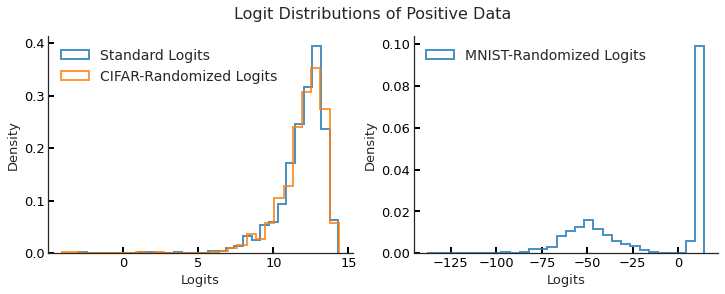

In [14]:
# Compute Standard, MNIST-Randomized and CIFAR-Randomized logits and AUCs

def get_logits(model, loader, device, label=1):
    X, Y = utils.extract_tensors_from_loader(loader)
    L = utils.get_logits_given_tensor(X, model, device=device).detach()
    L = L[Y==label].cpu().numpy()
    S = L[:, 1] - L[:, 0] # compute score / difference to get scalar 
    return S

SCP = {
    'std': get_logits(model, te_dl, device),
    'rand_mnist': get_logits(model, tem_dl, device),
    'rand_cifar': get_logits(model, tec_dl, device),
}

AUC = {
    'std': utils.get_binary_auc(model, te_dl, device),
    'rand_mnist': utils.get_binary_auc(model, tem_dl, device),
    'rand_cifar': utils.get_binary_auc(model, tec_dl,device),
}

print ("Standard AUC: {:.3f}".format(AUC['std']))
print ("MNIST-Randomized AUC: {:.3f}".format(AUC['rand_mnist']))
print ("CIFAR-Randomized AUC: {:.3f}".format(AUC['rand_cifar']))

# standard and randomized positive logit distributions
std_log, sc_log, s_log = SCP['std'], SCP['rand_cifar'], SCP['rand_mnist']

kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, "alpha": 0.8, "ls": '-'})

# plot logit distributions
kw = dict(kde=False, bins=30, norm_hist=True, 
          hist_kws={"histtype": "step", "linewidth": 2, 
                    "alpha": 0.8, "ls": '-'})

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))
sns.distplot(std_log, label='Standard Logits', ax=ax1, **kw)
sns.distplot(sc_log, label=r'CIFAR-Randomized Logits', ax=ax1, **kw)
sns.distplot(s_log, label=r'MNIST-Randomized Logits', ax=ax2, **kw)

utils.update_ax(ax1, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

utils.update_ax(ax2, '', 'Logits', 'Density', 
                ticks_fs=13, label_fs=13, title_fs=16, legend_fs=14, legend_loc='upper left')

fig.suptitle('Logit Distributions of Positive Data', fontsize=16)

The results above collectively show that in both datasets---slab-structured and mnist-cifar---FCNs and CNNs respectively do not mitigate simplicity bias. The ensembles still only rely on the simplest feature, as shown using the randomized AUCs and logits.